# Face_Blur preserving feature
### : Jaechan Jo, Sogang AI master's student
### - feature_inversion method
   * Blur the face 
   * preserving original feature as much as possible.

### - Structure
   * Face-detector(yolo_v5_face) + Blur-feature_inversion(squeeznet)
   * Image of Structure
   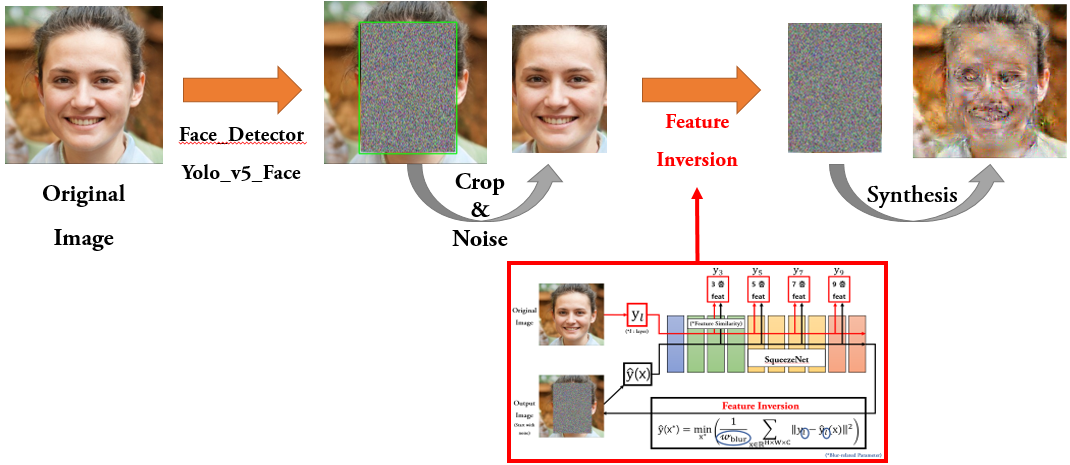

# Setup

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL
import cv2
import argparse
import numpy as np
import os
import time
from sklearn.model_selection import ParameterGrid
# !pip install imageio
from imageio import imread
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.image as img
# import visdom
# vis = visdom.Visdom()
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

In [8]:
# gpu or cpu

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
device

device(type='cuda')

In [ ]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),                                           
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0])
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def preprocess_rand(img):
    transform = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess_rand(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]), 
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x): # MINMAX Standardization
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

def loss_tracker(loss_plt, loss_value, num):
    '''num, loss_value are Tensor'''
    
    vis.line(X=num,
            Y=loss_value,
            win= loss_plt,
            update='append')

def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))


# Dataset

 - img_dir : Directory of image dataset
 - img_txt : Directory of image bbox coordinate txt
 - save_dir : Directory of saving images

In [ ]:
#Example

# img_dir = './face_data/resize/640/'
# img_txt = './face_data/bbox/640/'
# save_dir = './face_data/rand/640/'

# Face-Detection
   1. Preprocess
       * resize
       * 
   2. Run Yolo_v5_face_detector

In [ ]:
# resize image
def resize(img_dir, img_size, save_dir):
    img_list = os.listdir(img_dir)
    
    for img in img_list:
        img_path = img_dir + img
        img_name, _ = img.split('.')
        img= PIL.Image.open(img_path)
        
        resize = T.functional.resize(img, size=[img_size, img_size])
        
        resize.save(save_dir+img_name+f'_{img_size}.jpg', 'JPEG')
#test
# resize('./face_data/img/', 640, './face_data/resize/640/')

In [ ]:
# Extract bounding box coordinate (x1, y1, x2, y2)

!python ./yolov5_face_detection/test_widerface.py \
--weight ./yolov5_face_detection/weights/face_l.pt \
--img-size 640 \
--dataset_folder ./face_data/resize/640/ \
--folder_pict ./face_data/dir/resize_dir.txt \
--save_folder ./face_data/bbox/

# ex)
# python test_widerface.py \
# --weight weights/result_face_l.pt \
# --img-size 640 \
# --dataset_folder face_data/ \ 이미지만 존재하는 폴더 경로
# --folder_pict data/test/test_label.txt \ 이미지 경로를 모은 txt 파일(폴더의 모든 이미지)
# --save_folder widerface_evaluate/widerface_txt/ \ 이미지 size를 이름으로하는 폴더 자동 생성

In [ ]:
# Draw bounding box in image

!python ./yolov5_face_detection/draw.py \
--img_dir ./face_data/resize/640/ \
--img_txt ./face_data/bbox/640/ \
--save_dir ./face_data/draw/640/

# ex)
# python draw.py \
# --img_dir ./face_data/resize/640/ \ box 그리려는 모든 이미지 폴더 경로
# --img_txt ./face_data/bbox/640/ \ box 좌표가 있는 txt 폴더 경로
# --save_dir ./face_data/draw/ 결과물 저장 폴더 경로

In [ ]:
# Replace bbox with uniform random noise & save

def syn_face_rand(img_dir, img_txt, save_dir):
    img_list = os.listdir(img_dir)
    txt_list = os.listdir(img_txt)
    boxes = []
            
    for txt in txt_list:
        txt_path = img_txt + txt
        with open(txt_path, mode='r') as f:
            lines = f.readlines()

            for i  in range(len(lines)):
                lines[i]  = lines[i].strip('\n')

            obj = {'img_name':lines[0], 'obj_num':int(lines[1])}

            box_list = []
            for i in range(2, len(lines)):
                box_el = []
                x1, y1, w, h, score = lines[i].split(' ')
                box_el.append(int(x1))
                box_el.append(int(y1))
                box_el.append(int(w))
                box_el.append(int(h))
                box_el.append(float(score))
                box_list.append(box_el)

            obj['box'] = box_list
            boxes.append(obj)

    print('boxes : ', boxes)
    print('img_list : ', img_list)

    for img in img_list:
        img_path = img_dir + img
        img_name, _ = img.split('.')
        
        #read image
        image = cv2.imread(img_path)
        copy_image = image.copy()
        
        obj = next((item for item in boxes if item['img_name'] == img_name), None)
        for i in range(0, obj['obj_num']):
            if obj['box'][i][4] >= 0.5:
                x1 = obj['box'][i][0]
                y1 = obj['box'][i][1]
                x2 = obj['box'][i][0] + obj['box'][i][2]
                y2 = obj['box'][i][1] + obj['box'][i][3]
                
                # delete face bbox
                copy_image[y1:y2, x1:x2, :] -= copy_image[y1:y2, x1:x2, :]
        
                #synthesize uniform random noise
                rand_img = torch.Tensor(1,3,y2-y1,x2-x1).uniform_(0, 1).type(dtype)
                rand_img.requires_grad_()
                copy_image[y1:y2, x1:x2, :] += np.array(deprocess_rand(rand_img), dtype='uint8')
        
        #Save image
        cv2.imwrite(f"{save_dir}{img_name}_rand.jpg",copy_image)
        
        # show result
        plt.imshow(cv2.cvtColor(copy_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [ ]:
#Test

# img_dir = './face_data/resize/640/'
# img_txt = './face_data/bbox/640/'
# save_dir = './face_data/rand/640/'

# syn_face_rand(img_dir, img_txt, save_dir)

# Face-Blur
### - Squeeznet_feature_inverison
   * Sqeezenet Structure 
   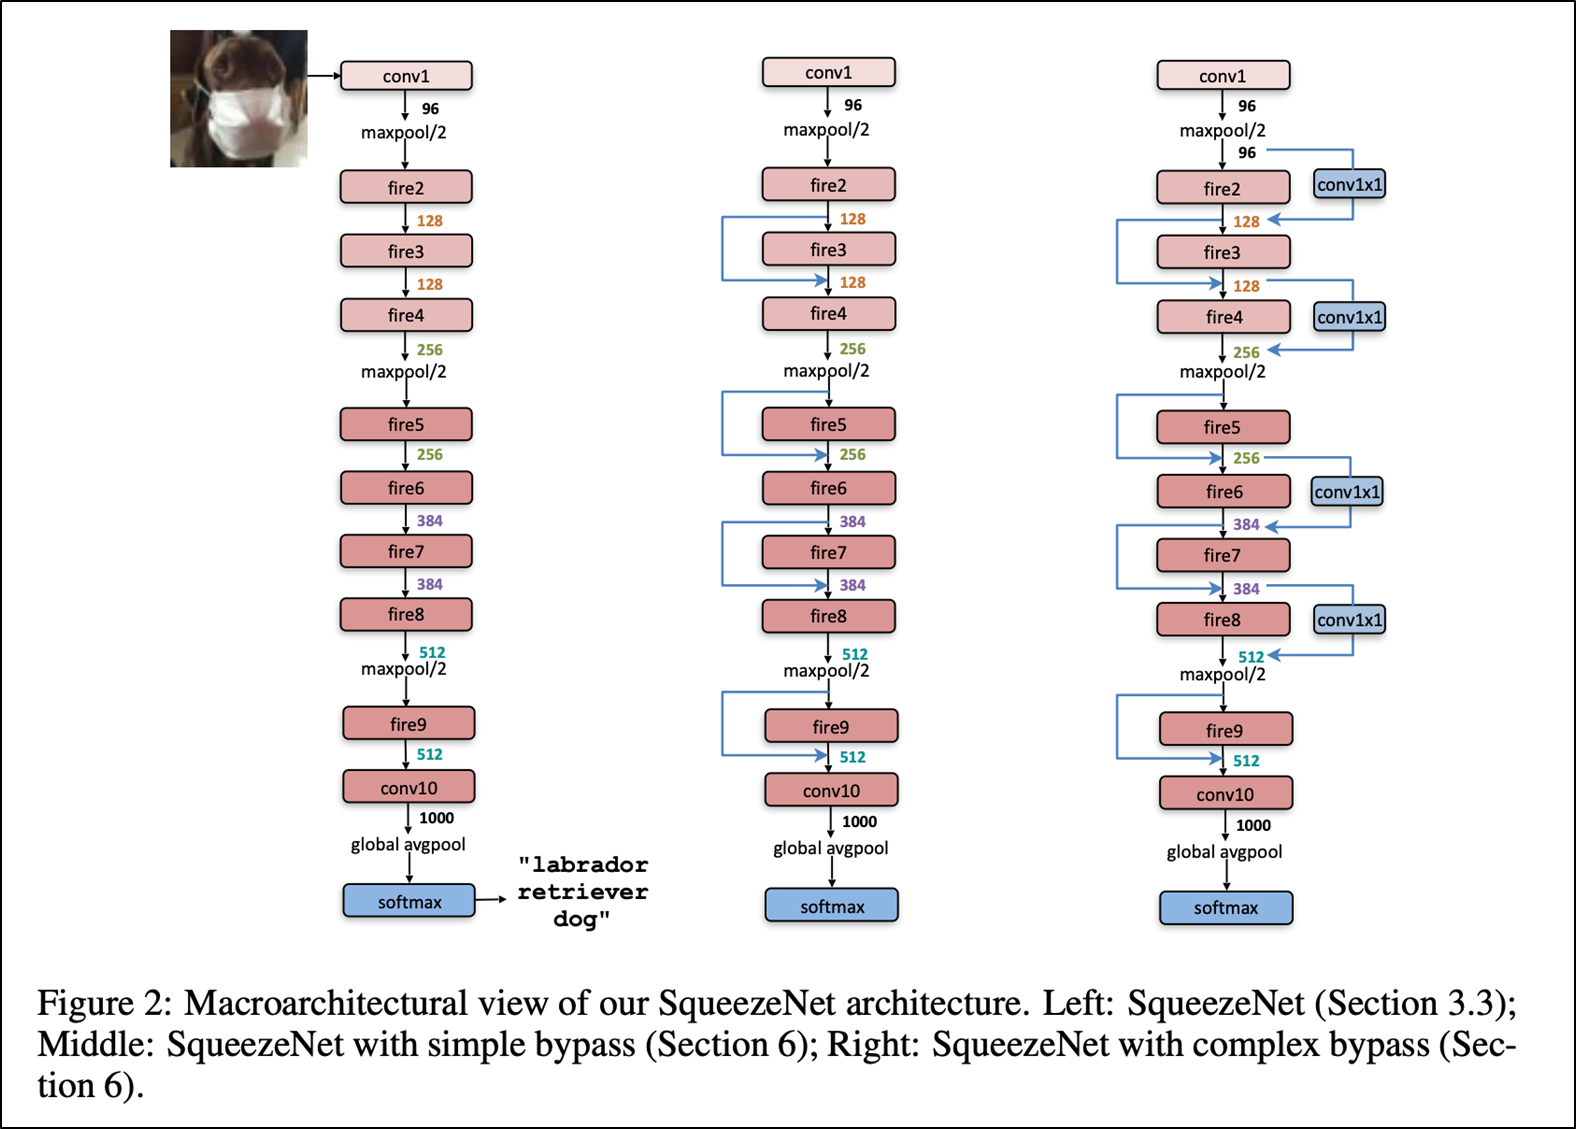
   * Feature Inversion
   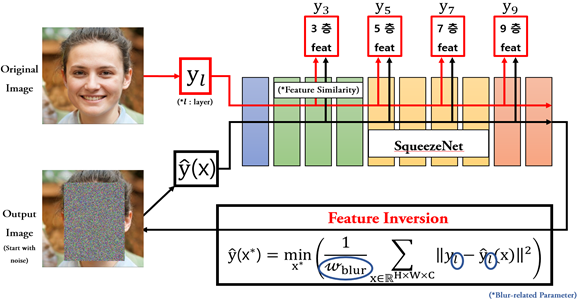

In [ ]:
# Load the pre-trained SqueezeNet model. (imagenet pretrained)
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)
cnn.to(device)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x.to(device)
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

# Face Loss Function
We can generate an image that reflects the face images of specific layer in our loss function. We can then use this face loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Face loss measures how much the feature map of the generated start image differs from the feature map of the original face image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the original image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_{blur}$ be the weight of the face loss term in the loss function. it's being higher then, weaker gradient decent more

Then the face loss is given by:

$L_{face} = 1/w_{blur} \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [ ]:
def face_loss(blur_weight, start_img, original_img):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - blur_weight: 비식별화 정도; 숫자가 커지면 커질수록 학습이 약해져,비식별화 정도가 강해진다
    - start_img : 비식별화하고자 하는 얼굴 부분에 Random noise를 준 이미지 feature ; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - original_img : 비식별화하고자 하는 얼굴 부분이 포함된 전체 이미지 feature ; Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar feature_loss
    """
    feature_loss = (1/blur_weight) * torch.sum((torch.pow(start_img - original_img, 2)))
    cos = torch.nn.CosineSimilarity(dim=0)
    cos_similarity = cos(torch.flatten(start_img), torch.flatten(original_img))
    return feature_loss, cos_similarity

In [ ]:
# Single version - Treat one image in a execution
def face_feature_inversion_sigle(img_path, start_img_path, sav_dir, image_size, target_layer,
                           blur_weight, epoch, check_iter, init_random = False):
    """
    Run face_blur!
    
    Inputs:
    - img_path: content image path ex) './face_data/img/face1.jpg'
    - start_img_path : start random image path for being face blur by feature inversion ex) './face_data/rand/face1_rand.jpg'
    - save_dir : directory you want to save
    - image_size: size you want to make image size
    - target_layer: the layer you try to do feature inversion from
    - blur_weight: the strength opposite to feature inversion, so higher more blur
    - epoch: how many you try to do feature inversion
    - check_iter: check intermediate result per the iteration
    ###(addition)
    - init_random: initialize the starting image to uniform random noise
    """
    
    #time check
    start_time = time.time()
    
    print(f"target_layer: {target_layer}/ blur_weight: {blur_weight/1e12}")
        
    # Extract features for the content image
    face_img = preprocess(PIL.Image.open(img_path), size=image_size)
    face_img = face_img.type(dtype)
    cfeats = extract_features(face_img, cnn)
    target_feature = cfeats[target_layer].clone()
    
    # start img input random noise in bbox
    rand_img = preprocess(PIL.Image.open(start_img_path), size=image_size)
    rand_img = rand_img.type(dtype).requires_grad_()
    
    # Set up optimization hyperparameters (0.9*epoch이 되면 lr를 0.1으로 줄여 천천히 update)
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 0.9*epoch

# Note that we are optimizing the pixel values of the image by passing
# in the rand_img whose requires_grad flag is set to True
# Check - Original_img vs Starting_img
    optimizer = torch.optim.Adam([rand_img], lr=initial_lr)

    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Original Face.')
    axarr[1].set_title('Starting img.')
    axarr[0].imshow(deprocess(face_img.cpu()))
    axarr[1].imshow(deprocess(rand_img.cpu()))
    plt.show()
    plt.figure()
    
# Tracker main clear all
#     vis.close(env='main')
    
#     # Setup plt of visdom
#     loss_plt = vis.line(Y=torch.Tensor([0], device='cpu'), 
#                        opts=dict(title=f'layer:{target_layer}/blur_w:{blur_weight/1e12}-Loss Tracker', legend=['loss'], showlegend=True))
#     sim_plt = vis.line(Y=torch.Tensor([0], device='cpu'), 
#                    opts=dict(title=f'layer:{target_layer}/blur_w:{blur_weight/1e12}-Similarity Tracker', legend=['similarity'], showlegend=True))
#     osim_plt = vis.line(Y=torch.Tensor([0], device='cpu'), 
#                    opts=dict(title=f'layer:{target_layer}/blur_w:{blur_weight/1e12}-Original Similarity Tracker', legend=['similarity'], showlegend=True))
    
    for t in range(epoch):
        if t < 0.95*epoch:
            rand_img.data.clamp_(-1.5, 1.5) #nonlinearity like relu

        optimizer.zero_grad()
        rfeats = extract_features(rand_img, cnn) #starting img feature map

        # Compute loss
        
        cos = torch.nn.CosineSimilarity(dim=0)
        cosine_similarity = cos(torch.flatten(rand_img), torch.flatten(face_img))
        
        loss, cos_similarity = face_loss(blur_weight, rfeats[target_layer], target_feature)
        loss.backward()

        # Perform gradient descents on our image values (0.9*epoch이 되면 lr를 0.1으로 줄여 천천히 update)
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([rand_img], lr=decayed_lr)
        optimizer.step()
        
        #Loss/cos-sim Tracker by Visdom

#         loss_tracker(loss_plt, torch.Tensor([loss]).detach().cpu(), torch.Tensor([t]).detach().cpu())               
#         loss_tracker(sim_plt, torch.Tensor([cos_similarity]).detach().cpu(), torch.Tensor([t]).detach().cpu())
#         loss_tracker(osim_plt, torch.Tensor([cosine_similarity]).detach().cpu(), torch.Tensor([t]).detach().cpu())

        if t % check_iter == 0:
            print('\n---------------------------------------------------------------\n')
            print(f'Iteration: {t}--runtime: {round(time.time()-start_time, 1)}sec')
            plt.axis('off')
            # show_result
            result = deprocess(rand_img.cpu())
            plt.imshow(result)
            plt.show()
            # save_result
            result.save(f'{sav_dir}result{target_layer}_{blur_weight/1e12}_{t}.jpg', 'JPEG')
            # print_evalution
            print(f'학습 정도, Loss : {loss}') 
            print(f'해당 층 feature map 유사도 : {cos_similarity}')
            print(f'원본 이미지와 유사도: {cosine_similarity}')

    print(f'Iteration {t}--runtime: {round(time.time()-start_time, 1)}sec')
    plt.axis('off')
    final_result = deprocess(rand_img.cpu())
    final_result.save(f'{sav_dir}final_result{target_layer}_{blur_weight/1e12}_{t}.jpg', 'JPEG')
    plt.imshow(final_result)
    plt.show()

In [ ]:
# Bounding box 좌표 값 불러오기
txt_path = './face_data/result/face_data/face1.txt'
boxes = []
with open(txt_path, mode='r') as f:
            lines = f.readlines()

            for i  in range(len(lines)):
                lines[i]  = lines[i].strip('\n')

            obj = {'img_name':lines[0], 'obj_num':int(lines[1])}

            box_list = []
            for i in range(2, len(lines)):
                box_el = []
                x1, y1, w, h, score = lines[i].split(' ')
                box_el.append(int(x1))
                box_el.append(int(y1))
                box_el.append(int(w))
                box_el.append(int(h))
                box_el.append(float(score))
                box_list.append(box_el)

            obj['box'] = box_list
            boxes.append(obj)

print('boxes : ', boxes)

# Quantative Evaluation
* Search Performance 
    * feature similarity of target layer 
    * between original and generated image


* De-identification
    * cosine distance of face 
    * between original and blur face

In [ ]:
# De-identification Loss

def De_identification(generate_crop, original_crop):
    """
    Compute the face de-identification loss.
    
    Inputs:
    - generate_crop : 생성 blur된 얼굴 부분 ; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - original_crop : 원본 얼굴 부분 ; Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar feature_loss
    """
    cos = torch.nn.CosineSimilarity(dim=0)
    cos_distance = 1 - cos(torch.flatten(generate_crop), torch.flatten(original_crop))
    return cos_distance*100

In [ ]:
# crop face & save

def crop_face(img_dir, img_txt, img_size, save_dir):
    img_list = os.listdir(img_dir)
    txt_list = os.listdir(img_txt)
    boxes = []
            
    for txt in txt_list:
        txt_path = img_txt + txt
        with open(txt_path, mode='r') as f:
            lines = f.readlines()

            for i  in range(len(lines)):
                lines[i]  = lines[i].strip('\n')

            obj = {'img_name':lines[0], 'obj_num':int(lines[1])}

            box_list = []
            for i in range(2, len(lines)):
                box_el = []
                x1, y1, w, h, score = lines[i].split(' ')
                box_el.append(int(x1))
                box_el.append(int(y1))
                box_el.append(int(w))
                box_el.append(int(h))
                box_el.append(float(score))
                box_list.append(box_el)

            obj['box'] = box_list
            boxes.append(obj)

    print('boxes : ', boxes)
    print('img_list : ', img_list)

    for img in img_list:
        img_path = img_dir + img
        img_name, _ = img.split('.') #original crop ver.
#         img_name1,img_name2, _ = img.split('.') #generated crop ver.

        image = PIL.Image.open(img_path)
        resize = T.functional.resize(image, size=[img_size, img_size]) # Img_size face_detection input_size와 통일
        copy_image = resize.copy()
        
        obj = next((item for item in boxes if item['img_name'] == img_name), None) #original crop ver.
#         obj = next((item for item in boxes if item['img_name'] == 'face3_640'), None) #generated crop ver.
        for i in range(0, obj['obj_num']):
            if obj['box'][i][4] >= 0.5:
                x1 = obj['box'][i][0]
                y1 = obj['box'][i][1]
                x2 = obj['box'][i][0] + obj['box'][i][2]
                y2 = obj['box'][i][1] + obj['box'][i][3]
                
                # pop face bbox
                cropped_image = T.functional.crop(copy_image, top=y1, left= x1, height= y2-y1, width= x2-x1)
                cropped_image.save(save_dir+img_name+f'_crop{i+1}.jpg', 'JPEG') #original crop ver.
#                 cropped_image.save(save_dir+img_name1+'.'+img_name2+f'_crop{i+1}.jpg', 'JPEG') #generate crop ver.
                
                # imshow crop face
                plt.imshow(cropped_image)
                plt.axis('off')
                plt.show()

In [ ]:
#Test

#original_crop

# img_dir = './face_data/resize/640/'
# img_txt = './face_data/bbox/640/'
# img_size = 640
# save_dir = './face_data/crop/640/ori/'

# crop_face(img_dir, img_txt, img_size, save_dir)

#generate_crop

# img_dir = './face_data/result2/192/multi/final_crop/'
# img_txt = './face_data/bbox/640/'
# img_size = 640
# save_dir = './face_data/crop/640/face3/'

# crop_face(img_dir, img_txt, img_size, save_dir)

In [ ]:
# Result De-identification Loss

original_crop = PIL.Image.open('./face_data/crop/640/ori/face3_640_crop1.jpg')
generate_crop_dir = './face_data/crop/640/face3/'

img_list = os.listdir(generate_crop_dir)

for img in img_list:
        img_path = generate_crop_dir + img
#         img_name, _ = img.split('.') #original crop ver.
        img_name1,img_name2, _ = img.split('.') #generate crop ver.
        
        if 'crop1' in img_name2:
            generate_crop = PIL.Image.open(img_path)
            print(f"{img_name1+'.'+img_name2} blur: { De_identification(preprocess_rand(generate_crop), preprocess_rand(original_crop)) }")
            
            #show image
            plt.imshow(generate_crop)
            plt.axis('off')
            plt.show()

# Appendix: synthesize
### - original image + cropped blur face

In [ ]:
# 원본이미지, 크롭 이미지 불러오기
original_image = './face_data/img/face1.jpg'
cropped_blur_image = './face_data/result/result/face1_crop1_result10000.jpg'

o_img = cv2.imread(original_image)
ori_img = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB) #cv2 BGR -> RGB(general)

c_img = cv2.imread(cropped_blur_image)
crop_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,2, figsize=(6,12))
ax = axes.flatten()
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(ori_img)
ax[1].imshow(crop_img)
plt.show()

In [ ]:
# Bounding box 좌표 값 불러오기
txt_path = './face_data/result/bbox/face1.txt'
boxes = []
with open(txt_path, mode='r') as f:
            lines = f.readlines()

            for i  in range(len(lines)):
                lines[i]  = lines[i].strip('\n')

            obj = {'img_name':lines[0], 'obj_num':int(lines[1])}

            box_list = []
            for i in range(2, len(lines)):
                box_el = []
                x1, y1, w, h, score = lines[i].split(' ')
                box_el.append(int(x1))
                box_el.append(int(y1))
                box_el.append(int(w))
                box_el.append(int(h))
                box_el.append(float(score))
                box_list.append(box_el)

            obj['box'] = box_list
            boxes.append(obj)

print('boxes : ', boxes)

In [ ]:
# Box 부분 값을 비우고, blur 사진 크기 맞춰서 합성하기
new_ori = ori_img.copy()

save_dir = './face_data/result/synthesis/'

obj = [item for item in boxes if item['img_name'] == 'face1']
for i in range(0, obj[0]['obj_num']):
    if obj[0]['box'][i][4] >= 0.5:
        x1 = obj[0]['box'][i][0]
        y1 = obj[0]['box'][i][1]
        x2 = obj[0]['box'][i][0] + obj[0]['box'][i][2]
        y2 = obj[0]['box'][i][1] + obj[0]['box'][i][3]
        #To zero(black) in bbox
        new_ori[y1:y2, x1:x2, :] -= new_ori[y1:y2, x1:x2, :]
        
        #crop_img resize for syntheis
        pil_c_img=PIL.Image.fromarray(crop_img)
        rs_c_img = T.functional.resize(pil_c_img, size=[y2-y1, x2-x1])
        r_crop_img = np.array(rs_c_img)
        
        #Synthesize cropped image to original
        new_ori[y1:y2, x1:x2, :] += r_crop_img
        
#         cropped_image.save(save_dir+img_name+f'_crop{i+1}.jpg', 'JPEG')

plt.imshow(new_ori)
plt.axis('off')
plt.show()

#save
PIL.Image.fromarray(new_ori).save(save_dir+'test.jpg', 'JPEG')

# Appendix: Similiarity btw original and blur in feature map
### - Cosine similiarity

In [ ]:
#Cosine Similiarity
cos = torch.nn.CosineSimilarity(dim=0)
cs = cos(torch.flatten(torch.Tensor(new_ori)), torch.flatten(torch.Tensor(ori_img)))
print(cs)

# Final Image Show
fig, axes = plt.subplots(1,2,figsize=(6,12))
ax = axes.flatten()
ax[0].imshow(new_ori)
ax[0].axis('off')
ax[1].imshow(ori_img)
ax[1].axis('off')
plt.show()